Import required libraries

In [16]:
import pandas as pd
import xarray as xr
import xesmf as xe
from matplotlib import pyplot as plt

%matplotlib inline

Open sample CaPA dataset and rename precipitation variable

In [112]:
ds = xr.open_dataset('../hourly/2011/2011010112_024.nc')
ds['precip_rate'] = ds.PR0_SFC*1000.0 / (60.0*60.0)

Open geogrid file for WRF-Hydro domain, rename dimensions, and drop time dimension

In [105]:
ds_out = xr.open_dataset('geo_em.d01.nc')
ds_out.rename({'XLONG_M': 'lon', 'XLAT_M': 'lat'}, inplace=True)
ds_out['lat'] = ds_out['lat'].sel(Time=0, drop=True)
ds_out['lon'] = ds_out['lon'].sel(Time=0, drop=True)

/Users/katelynw/miniconda3/envs/regrid/lib/python3.6/site-packages/xarray/conventions.py:536: SerializationWarning: variable 'LU_INDEX' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  stack_char_dim=stack_char_dim)


Create regridder object

In [106]:
regridder = xe.Regridder(ds, ds_out, 'bilinear', reuse_weights=True)

Reuse existing file: bilinear_510x518_1203x1582.nc


Regrid data array

In [107]:
dr = ds.precip_rate
dr_out = regridder(dr)

Plot first regridded image

(226000.640625, 1808000.625, 70999.3046875, 1273999.25)

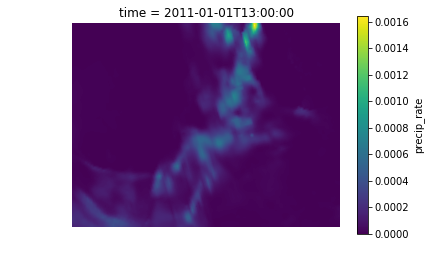

In [140]:
dr_out[0].plot()
plt.axis('scaled')
plt.axis('off')

Open spatial metadata file for domain

In [109]:
ds_sm = xr.open_dataset('GEOGRID_LDASOUT_Spatial_Metadata.nc')

Update metadata

In [113]:
dr_out = regridder(dr)
dr_out.coords['west_east'] = ds_sm.x.values
dr_out.coords['south_north'] = ds_sm.y.values
dr_out = dr_out.rename({'west_east': 'x', 'south_north': 'y'})
dr_out.attrs['esri_pe_string'] = ds_sm.ProjectionCoordinateSystem.attrs['esri_pe_string']
dr_out.attrs['units'] = 'mm/s'

Write to files

In [129]:
dates = pd.to_datetime(dr_out.time.values)
for i in range(dates.size):
    dr_out.isel(time=[i]).to_netcdf(dates[i].strftime('%Y%m%d%H')+'00.PRECIP_FORCING.nc')